# $P(E_{\rm{det}} | E)$

Figuring out the implementation in Stan.

In [1]:
import numpy as np
from scipy.interpolate import RectBivariateSpline

from matplotlib import pyplot as plt

## Load input from cascade_model

In [2]:
cond_file = ('data/conditional_2D_nue_CC_simulation_'
             +'gamma_1.0_lEmin_3.0_lEmax_7.0_fixed.txt')

In [3]:
dat = np.loadtxt(cond_file)

log_enu = dat[:,0]
log_edep = dat[:,1]

log_enu_axis = sorted(np.unique(log_enu))
log_edep_axis = sorted(np.unique(log_edep))

orig_cond_pdf = dat[:,2]
cond_pdf = []
for val in orig_cond_pdf:
    if val:
        cond_pdf.append(np.log10(val))
    else:
        cond_pdf.append(-20.)
        
cond_pdf = np.asarray(cond_pdf)
cond_pdf = cond_pdf.reshape(len(log_enu_axis), len(log_edep_axis))
cond_pdf = cond_pdf

pdf_spline = RectBivariateSpline(log_enu_axis, log_edep_axis, cond_pdf, 
                                 s=0, kx=1, ky=1) # spline degree = 1!

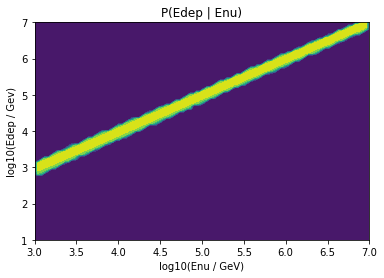

In [4]:
log10_Enu = np.linspace(3.0, 7.0, 100)
log10_Edep = np.linspace(1.0, 7.0, 100)

spline_val = np.zeros((100, 100))
for i, Enu in enumerate(log10_Enu):
    for j, Edep in enumerate(log10_Edep):
        spline_val[i][j] = pdf_spline(Enu, Edep)
        if spline_val[i][j] < -10:
            spline_val[i][j] = -10
        
        
fig, ax = plt.subplots()
ax.contourf(log10_Enu, log10_Edep, spline_val)
ax.set_xlabel('log10(Enu / GeV)')
ax.set_ylabel('log10(Edep / Gev)')
ax.set_title('P(Edep | Enu)');

In [31]:
# Spline info to pass to Stan:
p = 1  # spline degree (kx, ky above)
xknots, yknots = pdf_spline.get_knots()
xknots = np.unique(xknots)
yknots = np.unique(yknots)
Nx = len(xknots)+p-1 
Ny = len(yknots)+p-1 
c = pdf_spline.get_coeffs()
c = c.reshape(Nx, Ny)

## Normalisation

Would want to split into Enu bins and normalise along Edep? Pick Enu = 1e5 GeV as an example.

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(2, 3)

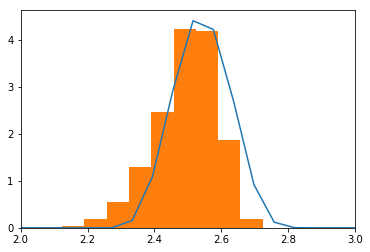

In [9]:
log_Enu = 5.0 # Gev
log_Edep = np.linspace(1.0, 7.0, 100)

prob = []
for E in log_Edep:
    p = 10**pdf_spline(log_Enu, E)[0][0]
    if p < 1e-5:
        p = 0
    prob.append(p)

norm = np.trapz(prob, log10_Edep)
    
# Compare with width of Gaussian currently used in Stan
s = np.random.normal(10**2.5, 0.2 * 10**2.5, 1000)

fig, ax = plt.subplots()
ax.plot(log_Edep, np.array(prob) / norm)
ax.hist(np.log10(s), normed=True)
ax.set_xlim(2, 3)

## Sampling from the distribution
Need to have a function which returns normalised dist for a given value of Enu. This is fairly easy in python. Could use spline + np.trapz in Stan to achieve the same?

In [28]:
def my_trapz(y_values, x_values):
    N = len(x_values)
    
    I = []
    for i in range(N-1):
        integ = 0.5 * (x_values[i+1] - x_values[i]) * (y_values[i]+y_values[i+1])
        I.append(integ)
        
    return sum(I)

def sample_Edet(Enu):
    log10_Enu = np.log10(Enu)
    
    # Find normalisation and maximum
    log10_Edet_grid = np.linspace(1.0, 7.0, 100)
    p_grid = [10**pdf_spline(log10_Enu, _)[0][0] for _ in log10_Edet_grid]
    norm = my_trapz(p_grid, log10_Edet_grid)
    p_max = max(np.array(p_grid) / norm)
    
    # Sampling
    accepted = False
    while not accepted:
        log10_Edet = np.random.uniform(1, 7)
        p = np.random.uniform(0, p_max)
        if p <= 10**pdf_spline(log10_Enu, log10_Edet)[0][0] / norm:
            accepted = True
            
    return 10**log10_Edet

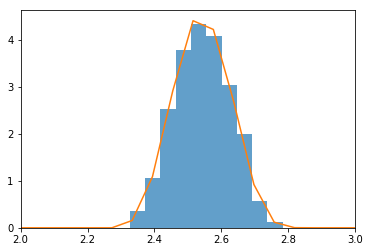

In [29]:
# Compare distribution & samples
log10_Edet_samples = [np.log10(sample_Edet(1e5)) for i in range(1000)]

fig, ax = plt.subplots()
ax.hist(log10_Edet_samples, density=True, alpha=0.7)
ax.plot(log_Edep, np.array(prob) / norm)
ax.set_xlim(2, 3);